In [1]:
import os
if not os.path.exists('Faceswap-Deepfake-Pytorch'):
    !wget -q https://www.dropbox.com/s/5ji7jl7httso9ny/person_images.zip
    !wget -q https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py
    !unzip -q person_images.zip
!pip install -q torch_snippets torch_summary
from torch_snippets import *
from random_warp import get_training_data

^C


In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
def crop_face(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if(len(faces)>0):
        for (x,y,w,h) in faces:
            img2 = img[y:(y+h),x:(x+w),:]
        img2 = cv2.resize(img2,(256,256))
        return img2, True
    else:
        return img, False

In [ ]:
!mkdir cropped_faces_personA
!mkdir cropped_faces_personB

def crop_images(folder):
    images = Glob(folder+'/*.jpg')
    for i in range(len(images)):
        img = read(images[i],1)
        img2, face_detected = crop_face(img)
        if(face_detected==False):
            continue
        else:
            cv2.imwrite('cropped_faces_'+folder+'/'+str(i)+'.jpg',cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))
crop_images('personA')
crop_images('personB')

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        self.items_A = np.concatenate([read(f,1)[None] for f in items_A])/255.
        self.items_B = np.concatenate([read(f,1)[None] for f in items_B])/255.
        self.items_A += self.items_B.mean(axis=(0, 1, 2)) - self.items_A.mean(axis=(0, 1, 2))

    def __len__(self):
        return min(len(self.items_A), len(self.items_B))
    def __getitem__(self, ix):
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b

    def collate_fn(self, batch):
        imsA, imsB = list(zip(*batch))
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB

a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)

══════════════════════════════════════════════════════════════════

Tensor  Shape: torch.Size([32, 3, 64, 64])      Min: -0.000     Max: 0.884      Mean: 0.509     dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

Tensor  Shape: torch.Size([32, 3, 64, 64])      Min: 0.024      Max: 0.936      Mean: 0.498     dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

Tensor  Shape: torch.Size([32, 3, 64, 64])      Min: 0.002      Max: 0.883      Mean: 0.509     dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

Tensor  Shape: torch.Size([32, 3, 64, 64])      Min: 0.026      Max: 0.934      Mean: 0.500     dtype: 
torch.float32 @ cuda:0

══════════════════════════════════════════════════════════════════

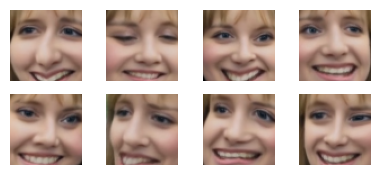

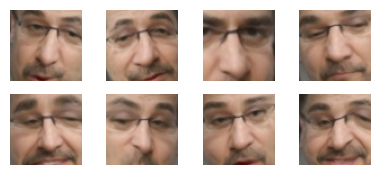

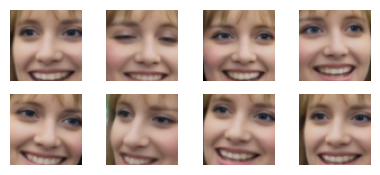

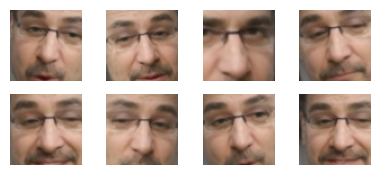

In [ ]:
inspect(*next(iter(x)))

for i in next(iter(x)):
    subplots(i[:8], nc=4, sz=(4,2))

In [ ]:
def _ConvLayer(input_features, output_features):
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        output = input.view(-1, 1024, 4, 4) # channel * 4 * 4
        return output

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out

In [ ]:
def train_batch(model, data, criterion, optimizes):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')

    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)
    
    lossA.backward()
    lossB.backward()

    optA.step()
    optB.step()

    return lossA.item(), lossB.item()

In [ ]:
model = Autoencoder().to(device)

dataset = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)

optimizers = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999)), \
             optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}], 
                        lr=5e-5, betas=(0.5, 0.999))
             
criterion = nn.L1Loss()

In [ ]:
n_epochs = 10000
log = Report(n_epochs)
!mkdir checkpoint
for ex in range(n_epochs):
    N = len(dataloader)
    for bx,data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        log.record(ex+(1+bx)/N, lossA=lossA, lossB=lossB, end='\r')

    log.report_avgs(ex+1)
    if (ex+1)%100 == 0:
        state = {
                'state': model.state_dict(),
                'epoch': ex
            }
        torch.save(state, './checkpoint/autoencoder.pth')

    if (ex+1)%100 == 0:
        bs = 5
        a,b,A,B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        x = torch.cat([B[:bs],_a,_b])
        subplots(x, nc=bs, figsize=(bs*2, 5))

log.plot_epochs()

Output hidden; open in https://colab.research.google.com to view.